In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
fontsize = 20
from functools import partial
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy import interpolate
from scipy.stats import wilcoxon
from numpy.fft import fft, ifft, fftfreq
from time import time
from tqdm import tqdm

from tqdm import trange
from best_subset import *
from solvel0 import solvel0
from pde_diff_new import RPCA
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff
import pynumdiff
import pynumdiff.optimize
import sys; sys.path.insert(0, "../derivative/"); import derivative
from derivative import dxdt as ddd

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.preprocessing import normalize as sk_normalize

from findiff import FinDiff
from abess.linear import LinearRegression
from UBIC import fit_blr, UBIC, decreasing_values_indices
from skscope_tools import best_subset_all_solutions, abess_all_solutions
from para_UBIC import *

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.0


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

# Set size of grid -> affect discovery results
n = 256
m = 256
    
# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T # shape = (len(x), len(t))

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

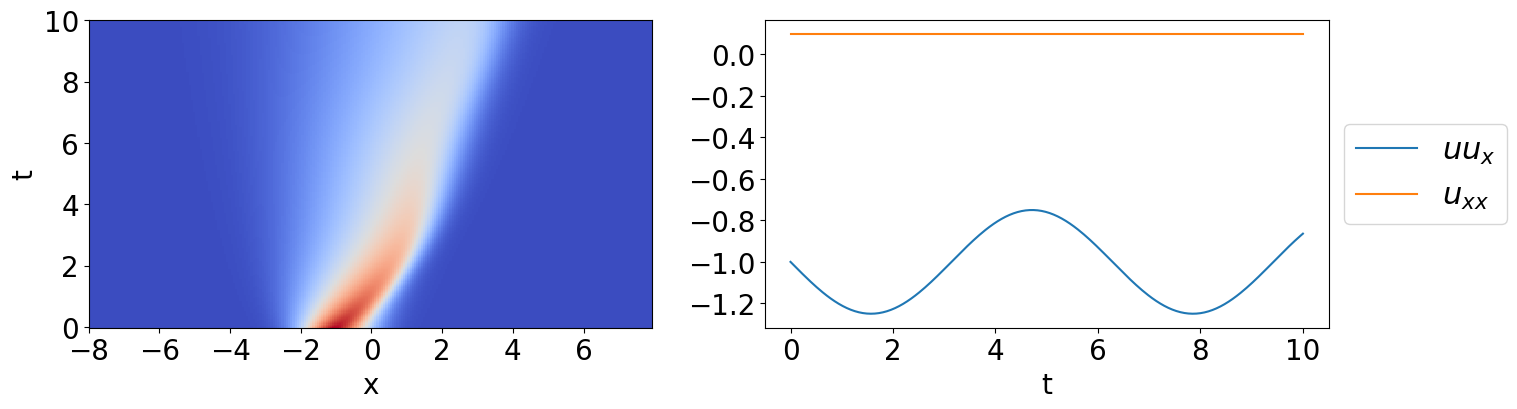

In [3]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [4]:
u_clean = u.copy()
u_clean_t = FinDiff(1, dt, 1, acc=4)(u_clean)
u_clean_x = FinDiff(0, dx, 1, acc=4)(u_clean)
u_clean_xx = FinDiff(0, dx, 1, acc=4)(u_clean_x)
u_clean_xxx = FinDiff(0, dx, 1, acc=4)(u_clean_xx)
u_clean_xxxx = FinDiff(0, dx, 1, acc=4)(u_clean_xxx)
noise_lv = 2
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(n, m)

In [5]:
include_bias = False
is_denoising = True

if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=1)

ttt = u.copy()
alpha = 1e-3
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=include_bias, 
                                                                              dependent='temporal')
# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "temporal")

In [6]:
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

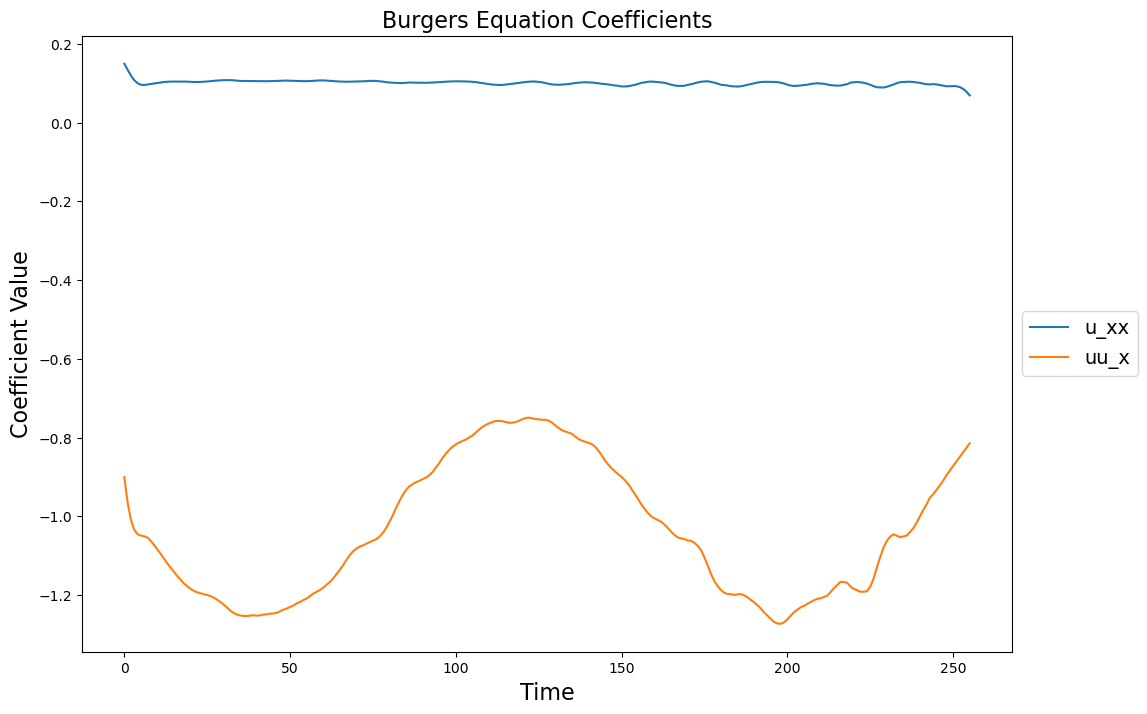

In [7]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=2)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]:
    plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [8]:
# 0.1821324868907128
xi = xi[np.where(np.linalg.norm(xi, axis=-1))[0]]
errors = np.array([coeff_error(xi[0], u_xx_true), coeff_error(xi[1], uu_x_true)])
print(errors)
errors.mean(), errors.std()

[4.57102406 1.09773114]


(2.834377598233754, 1.7366464595718325)

In [9]:
candidates = set()
max_complexity = 10 # X_weak.shape[-1]

normalized_Theta_grouped, normalized_Ut_grouped = normalize_groups(Theta_grouped, 
                                                                   Ut_grouped, 
                                                                   2)

counter = {0}; i = 0
max_counter = 30
while True:
    bs_i = solvel0(normalized_Theta_grouped[i], 
                   normalized_Ut_grouped[i], 
                   max_complexity=max_complexity, 
                   miosr=True, refine=True, verbose=False)
    
#     bs_i = best_subset_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
#     bs_i = abess_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
    bs_i = list(map(tuple, bs_i))
    candidates = candidates.union(bs_i)
    
    if len(counter) == max_counter: break
        
    print(len(counter))
    i = np.random.choice(len(Theta_grouped))
    while i in counter:
        i = np.random.choice(len(Theta_grouped))
    counter.add(i)

candidates

Set parameter Username


2024-02-18 14:49:05,996 [INFO] Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-04


2024-02-18 14:49:05,999 [INFO] Academic license - for non-commercial use only - expires 2024-06-04


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


{(0, 1, 2, 3),
 (0, 1, 2, 3, 5, 7, 9, 11),
 (0, 1, 2, 3, 5, 7, 11),
 (0, 1, 2, 3, 7),
 (0, 1, 2, 3, 7, 9, 11),
 (0, 1, 2, 3, 7, 10, 11, 15, 16, 17),
 (0, 1, 2, 3, 7, 17),
 (0, 1, 2, 3, 16),
 (0, 1, 2, 4, 5, 6, 7, 8, 9, 10),
 (0, 1, 3, 4, 5, 7, 11, 12, 18),
 (0, 1, 3, 4, 6, 7, 13, 14, 16, 17),
 (0, 1, 3, 4, 6, 7, 13, 15, 16, 17),
 (0, 1, 3, 4, 6, 7, 13, 15, 17),
 (0, 1, 3, 4, 6, 7, 15, 17),
 (0, 1, 3, 4, 7, 8, 11),
 (0, 1, 3, 4, 7, 8, 11, 18),
 (0, 1, 3, 4, 7, 9, 11),
 (0, 1, 3, 4, 7, 11, 12),
 (0, 1, 3, 4, 7, 11, 12, 13, 14, 18),
 (0, 1, 3, 4, 7, 11, 12, 14, 18),
 (0, 1, 3, 4, 7, 15, 16),
 (0, 1, 3, 4, 7, 15, 16, 17),
 (0, 1, 3, 5, 7, 9, 10, 11, 12, 16),
 (0, 1, 3, 5, 7, 9, 11, 17),
 (0, 1, 3, 5, 7, 10, 12, 13, 15),
 (0, 1, 3, 5, 7, 10, 12, 15, 17),
 (0, 1, 4, 6, 7, 8, 10, 11, 16),
 (0, 1, 4, 6, 7, 8, 10, 11, 16, 17),
 (0, 1, 4, 6, 7, 9, 11, 15, 17),
 (0, 1, 4, 6, 7, 9, 11, 17),
 (0, 1, 4, 6, 7, 11, 13, 17),
 (0, 1, 4, 7, 8, 9),
 (0, 1, 4, 7, 8, 9, 10, 15),
 (0, 1, 4, 7, 8, 10, 11),
 (

In [10]:
lam = 0
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print("lam:", lam)

track = {}
for indices in tqdm(candidates):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss

candidates = set([e[0] for e in list(track.values())])
candidates

lam: 0.0002475871855954709


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:34<00:00,  5.35it/s]


{(0, 1, 3, 4, 5, 7, 11, 12, 18),
 (0, 1, 3, 4, 6, 7, 15, 17),
 (0, 1, 3, 4, 7, 11, 12, 13, 14, 18),
 (0, 1, 3, 4, 7, 15, 16),
 (0, 1, 4, 7, 8, 9),
 (3,),
 (4, 6, 7, 10),
 (4, 7),
 (4, 7, 8, 10, 17),
 (4, 7, 10)}

aic: 10
bic: 10


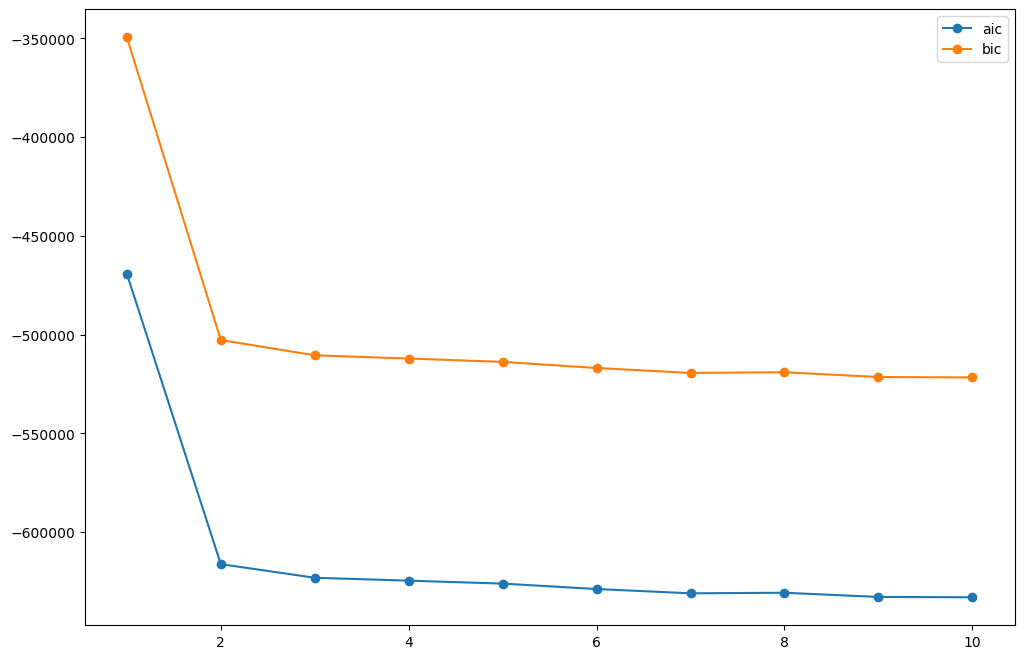

In [11]:
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
    aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]

print("aic:", complexities[np.argmin(aics)])
print("bic:", complexities[np.argmin(bics)])
plt.plot(complexities, aics, '-o', label='aic')
plt.plot(complexities, bics, '-o', label='bic'); plt.legend(); plt.show()

In [12]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):        
        # model = Ridge(alpha=lam, fit_intercept=False)
        model = BayesianRidge(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j].flatten())
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction, 'fro')**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 1139.30it/s]


In [13]:
# nobs = Theta_grouped[0].shape[0]*len(Ut_grouped)
# min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
# epsilon = max(1e-5, np.max([2*np.pi*best_subsets[com][0]/nobs for com in best_subsets]))
# epsilon = 1e-5
# print("epsilon", epsilon)
# complexities = sorted(best_subsets.keys())
# bics = []
# uncertainties = []
# for com in complexities:
#     rss, uncert, indices = best_subsets[com]
#     uncert = uncert/min_uncert
#     uncertainties.append(uncert)
#     bics.append(rss2bic(rss, com, nobs, epsilon))
# uncertainties = np.array(uncertainties)
# best_indices = best_subsets[complexities[np.argmin(bics)]][-1]
# print(complexities[np.argmin(bics)])
# print(best_indices)
# plt.plot(complexities, bics, '-o'); plt.show()

#### in PSD space

In [14]:
complexities = sorted(best_subsets.keys())

min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
uncertainties = []
for com in complexities:
    _, uncert, _ = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
uncertainties = np.array(uncertainties)

nfft = max(fft_Ut_grouped[:, :, 0].shape)
nfft = None
ground_periogram = periodogram(ifft(fft_Ut_grouped[:, :, 0]), nfft=nfft)[-1]
nobs = np.prod(ground_periogram.shape)
epsilons = []
for com in complexities:
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
        est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                            Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
    pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    pred_periogram = periodogram(pred_group, nfft=nfft)[-1]

    res = np.vstack([ground_periogram[j]-pred_periogram[j] for j in range(len(Theta_grouped))])
    rss = np.linalg.norm(res, ord='fro')**2
    epsilons.append(2*np.pi*rss/nobs)
epsilon = max(epsilons)
epsilon

0.0013863579892290498

9


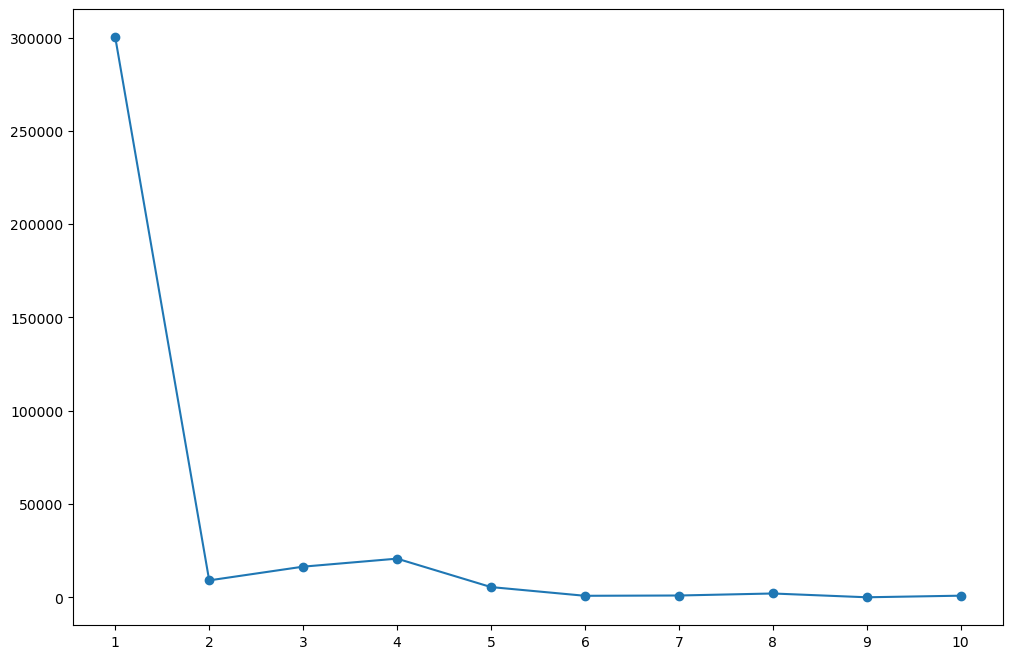

In [15]:
epsilon = 1e-5
ics = []
rss_list = []
varying_bics = []
for com in complexities:
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
        est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                            Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
        post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
        ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))
        
    pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    pred_periogram = periodogram(pred_group, nfft=nfft)[-1]

    res = np.vstack([ground_periogram[j]-pred_periogram[j] for j in range(len(Theta_grouped))])
    rss = np.linalg.norm(res, ord='fro')**2
    ics.append(nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*com)
    rss_list.append(rss)
    varying_bics.append(vbics)
    
varying_bics = np.array(varying_bics)
varying_bics_ranking = np.argsort(varying_bics.sum(axis=-1))
print(np.argmin(ics)+1)
plt.plot(complexities, ics-min(ics), '-o')
plt.xticks(complexities)
plt.show()

#### With tuned UBIC

In [16]:
verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    _, _, indices = best_subsets[com]
    rss = rss_list[com-1]
    assert com == len(indices)
    lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
    
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = np.argmin(last_ubic)

thres = 1e-4
percent = 75 # 75 # 90 (เพราะไม่เอา complexity = 1)
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))
pcut = 0.01

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    diff_vbic = (varying_bics[now_bc]-varying_bics[last_bc])
    
    diff_vbic_adj = np.array([-np.inf for _ in range(1000)])
    adj_bc = varying_bics_ranking[varying_bics_ranking<now_bc]
    if len(adj_bc) > 0:
        adj_bc = adj_bc[0]
        diff_vbic_adj = varying_bics[now_bc]-varying_bics[adj_bc]

    imp = np.nan
    pvalue_pos = pvalue_neg = pvalue_adj = np.nan
    if np.abs(diff_com) > 0:
        # imp < thres <--> pvalue > pcut
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
        pvalue_pos = wilcoxon(diff_vbic, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_vbic, alternative='less').pvalue
        pvalue_adj = wilcoxon(diff_vbic_adj, alternative='less').pvalue

    # new version using wilcoxon test
    if verbose:
        print(last_bc, '--->', adj_bc, '--->', now_bc, 'p-value:', 
              np.nan_to_num(pvalue_pos, nan=np.inf), 
              np.nan_to_num(pvalue_neg, nan=np.inf), 
              np.nan_to_num(pvalue_adj, nan=np.inf))
    if (diff_com > 0 and (diff_bic > 0 or pvalue_pos > pcut or pvalue_adj > pcut)) or \
        (diff_com < 0 and diff_bic > 0 and pvalue_pos > pcut and pvalue_neg <= pcut):
        break

    ### old version using threshold ###
#     if verbose:
#         print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))
#     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
#         (diff_com < 0 and diff_bic > 0 and imp > thres):
#         break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)
    
last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
last_lam, last_ubic, last_bc

1 ---> 0 ---> 1 p-value: inf inf inf
1 ---> 1 ---> 5 p-value: 1.0 4.255062550348794e-24 1.0
(4, 7) selected


(3.20905428,
 array([-396389.94775513, -704035.50144418, -692739.42972863,
        -686812.22230085, -634568.43025889, -606726.51282415,
        -311318.32981012, -368836.98793757, -266957.11109402,
        -100769.10106571]),
 1)

#### Verification process

In [17]:
varying_bics = []
pvalues = [0.0]
for indices in sorted(candidates, key=len):
    vbics = []
    for j in range(0, len(Theta_grouped), 1):
        model = BayesianRidge(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        # periodogram calculation like weak formulation
        post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
        ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))
    pvalue = np.nan
    if len(varying_bics) > 0:
        wres = wilcoxon(vbics, varying_bics[-1], alternative='less')
        pvalue = wres.pvalue
        pvalues.append(pvalue)
    varying_bics.append(vbics)
    print(indices, pvalue)
    
varying_bics = np.array(varying_bics)
# summ_bics = varying_bics.sum(axis=-1)
# assert len(summ_bics) == len(pvalues)

(3,) nan
(4, 7) 4.820209256947899e-44
(4, 7, 10) 0.9999998672354357
(4, 6, 7, 10) 1.4635871517270399e-06
(4, 7, 8, 10, 17) 0.9999893925920963
(0, 1, 4, 7, 8, 9) 0.007561378507894907
(0, 1, 3, 4, 7, 15, 16) 0.8732254176332594
(0, 1, 3, 4, 6, 7, 15, 17) 0.13446910572311982
(0, 1, 3, 4, 5, 7, 11, 12, 18) 0.27863292789626204
(0, 1, 3, 4, 7, 11, 12, 13, 14, 18) 0.9999962422787299


In [18]:
pcut = 0.01
min_bic = np.inf
j = None
for i, pvalue in enumerate(pvalues):
    if i == 0: pvalue = 0.0
    else: pvalue = wilcoxon(varying_bics[i]-varying_bics[j], alternative='less').pvalue
    if ics[i] < min_bic and pvalue < pcut:
        min_bic = ics[i]
        j = i
        if pvalue < pcut:
            print(i+1)

1
2
